## <center> Air Pollution in Vietnam</center>
#### Business Task

The purpose of this analysis is to analyze the most relevant data of the last five years to determine trends in air pollution and vehicle sales within Vietnam and to discover the resulting correlations and insights, if any.

Understanding these trends provides greater for key stakeholders, such as lawmakers, to determine which sort of action they will take to address the situation.

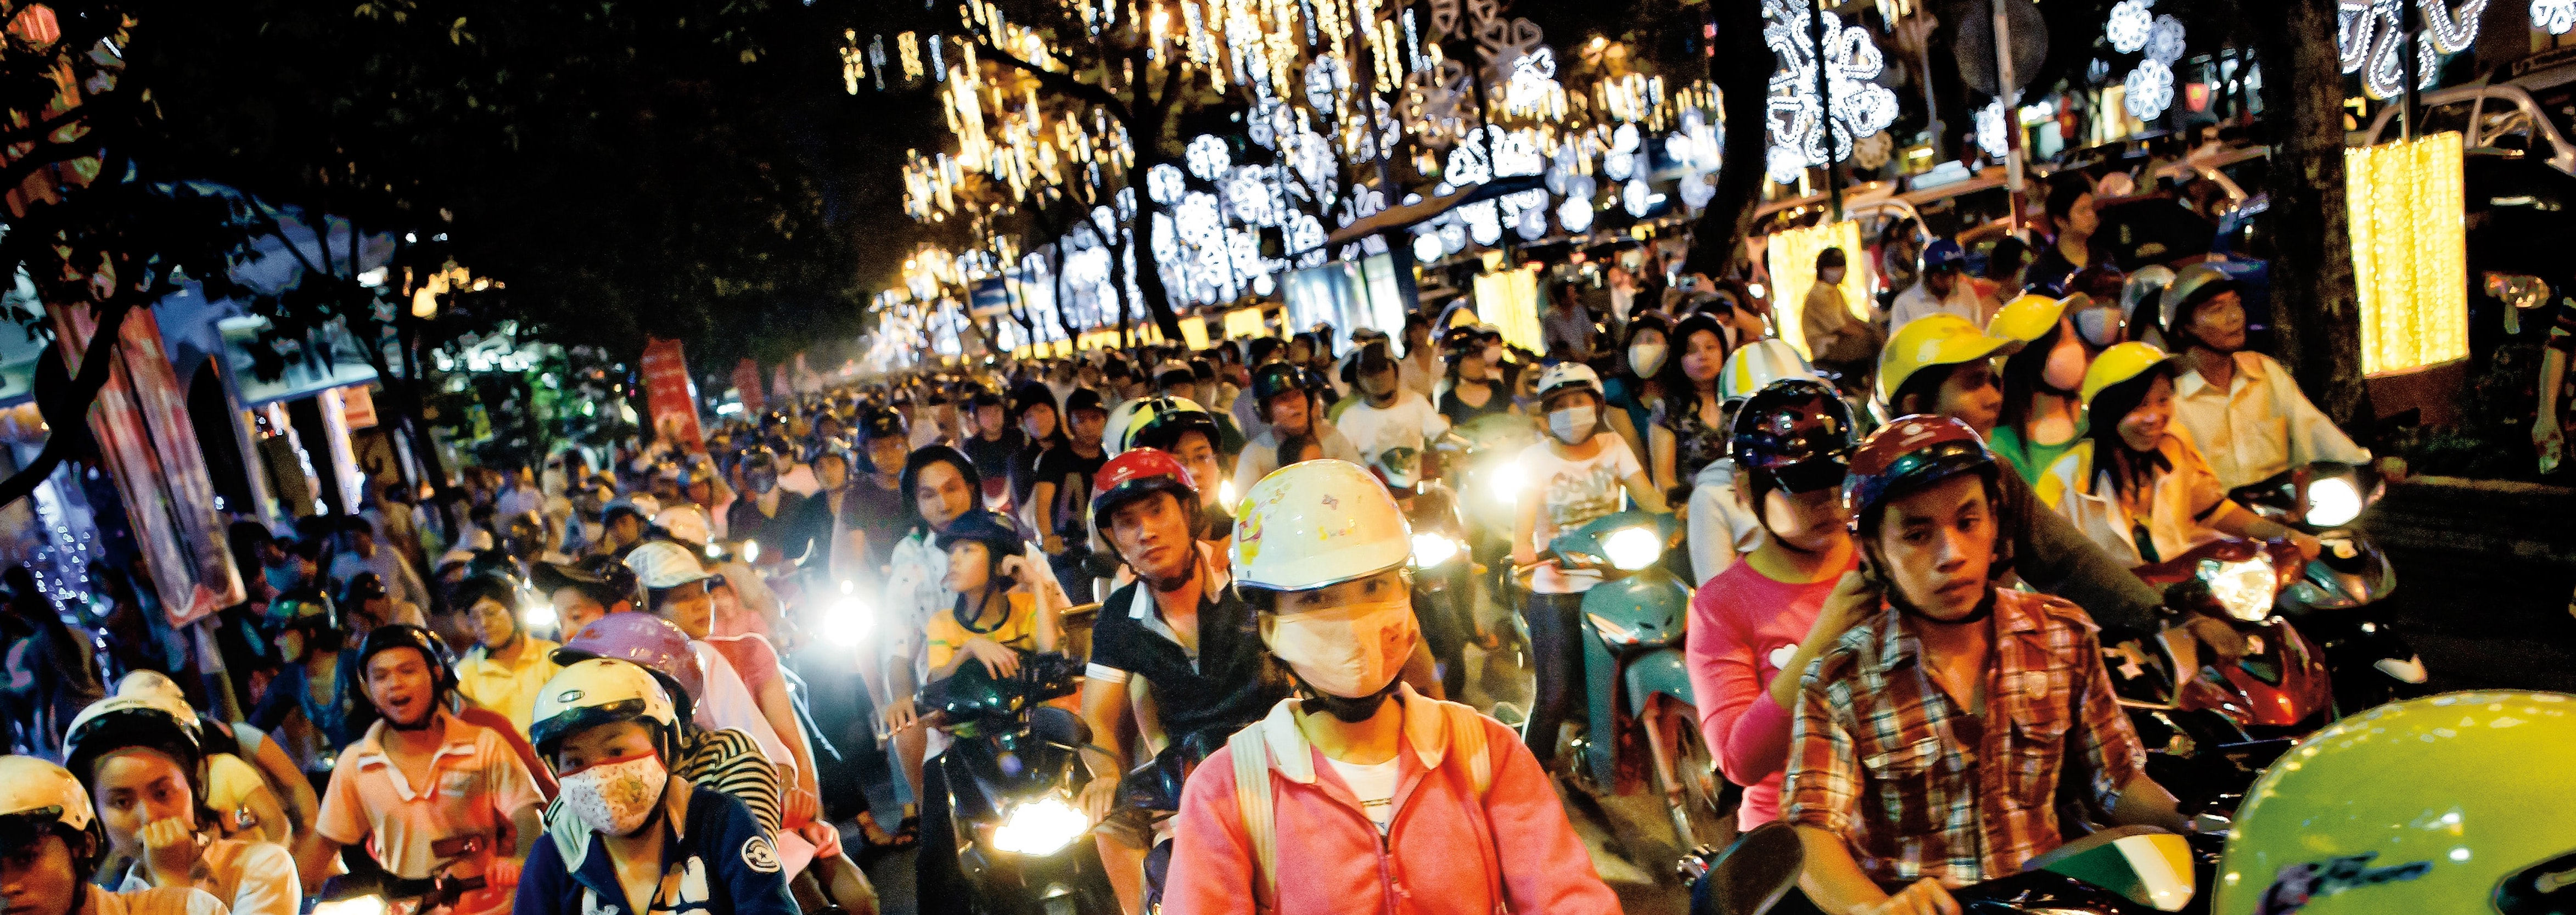

*Image courtesy of [Matthew Nolan](https://unsplash.com/photos/a_89Onshm3I)*

#### Data Required

This is a complex problem and, at a minimum the dataset needs to includes:
* Detailed data on a measure of the air quality over the duration of the analysis
* Vehicle sales data, including cars and motorcycles, over the duration of the analysis
    * Records of amount of vehicles currently in use
* Data that verifies the link (or lack therof) between vehicles and air pollution.

Supplementary data to confirm any attributions or recognized trends is also important.

### <center>Data Sourcing</center>

Careful attention was paid to sourcing the data from unbiased and reputable organizations. All data can be accessed publicly and is available from the following links:
* **Air pollution data is from AirNow.** 
    * Ha Noi: [Data](https://www.airnow.gov/international/us-embassies-and-consulates/#Vietnam$Hanoi)
    
    * Ho Chi Minh City: [Data](https://www.airnow.gov/international/us-embassies-and-consulates/#Vietnam$Ho_Chi_Minh_City)
    
"AirNow is a partnership of the U.S. Environmental Protection Agency (EPA), National Oceanic and Atmospheric Administration (NOAA), National Park Service, NASA, Centers for Disease Control," and other agencies that provides air quality information across the United States and the world. (About [AirNow](https://www.airnow.gov/about-airnow/))


* **Global GDP and Vietnam's GDP data were sourced from World Bank.** [Data](https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?locations=VN) 

"The [World Bank](https://data.worldbank.org/about) is an international organization dedicated to providing financing, advice, and research to developing nations to aid their economic advancement." [More About the World Bank](https://www.investopedia.com/terms/w/worldbank.asp) 


Vehicle sales data was collected from these two authorities:
* **Vietnam Automobile Manufacturer Association (VAMA):** [Data](http://vama.org.vn/en/sales-report.html?Page=1)

"The Vietnam Automobile Manufacturers' Association (VAMA) is a non-governmental, non-political and non-profitable organization." Among their main activities are "to compile, correlate statistical data on the Vietnamese automotive industry." [About](http://vama.org.vn/en/introduction.html)
* **Vietnam Association of Motorcycle Manufacturers (VAMM):** [Data](https://vamm.vn/sales-data/)

"The Vietnam Association of Motorcycle Manufacturers is an organization established under the Ministry of Home Affairs that acts "as a bridge between local motorcycle Manufacturers and the Government." 

Their stated purpose is "to build a forum to connect motorcycle manufacturers in Vietnam, apply advanced technologies upon global standards, manufacture motorcycle of high quality, safety, environmental friendliness, assure the healthy competitive environment in the sector of motorcycle manufacturing." [About](https://vamm.vn/introduction/)

### <center> Data Processing </center>

#### Sales Data

Sales data was compiled from the VAMA and VAMM websites into a single CSV. As motorcycle sales data is only provided quarterly, data from the automotive sector was summed into quarters so that data could be appropriately visualized. 

Initially, motorcycle sales data was published semiannually. Therefore, the first quarter's data in the CSV is 50% of the semiannual figure.

#### World GDP

Within Google Sheets, GDP was only filtered to include Vietnam's GDP from 2016-2021, but no other filters, sorts or any change were mate to the data.

#### Air Quality

Air quality data required more extensive cleaning and preparation.

Google Sheets was used to clean data before it was analyzed. Air quality data was cleaned as below:
* Filter for and delete rows that category "QC Name" noted as:
    * Missing, 
    * Invalid *or* 
    * Suspicious
* Filter for data in the categories "NowCast Conc.", "AQI" and "AQI Conc." with the value `-999` or `0` and delete rows
* Check data for extra spaces and repeated rows (none were found).


Once cleaning was complete it was uploaded to BigQuery as two CSV files for Ho Chi Minh City and Ha Noi respectively.

Following the above process, this dataset was uploaded to BigQuery for analysis. The data originally tracked all hourly readings of air quality. The first adjustment reduced it to daily averages. 

In order to ensure the query worked correctly, a number of random collections were taken within the cleaned source CSV and averaged. Only if all of these samples returned exact matches did I continue with either of the two below queries.

The only difference between the Hanoi and HCMC queries are that the `FROM` line will change to `air-quality-analysis-320407.air_pollution.hn_aq`. The query details are below:

```SQL
SELECT 
    Year,
    Month,
    Day,
    SUM(AQI)/COUNT(Hour) AS avg_aqi

FROM `air-quality-analysis-320407.air_pollution.hcmc_aq` AS project

WHERE 
    QC_Name <> 'Missing'

GROUP BY
    Year,
    Month,
    Day

HAVING  
    avg_aqi > 0
    AND COUNT(Hour) = 24

ORDER BY 
    Year,
    Month,
    Day
```

After grouping data into daily statistics, it was saved as a new table and queried further in similar fashion to return monthly averages. See below for the query details 

*`air-quality-analysis-320407.air_pollution.hn_daily` returns data for Hanoi.*

```SQL
    SELECT 
    Year,
    Month,
    SUM(avg_aqi)/COUNT(Day) AS mo_aqi

FROM `air-quality-analysis-320407.air_pollution.hcmc_daily`

GROUP BY 
    Year,
    Month

ORDER BY 
    Year,
    Month
```

### <center>Analysis</center>

This section is a record of the calculations I used to performe analyses on the data, including visualizations and trends discovered. The next section covers findings. 

Initially I averaged the AQI over the entire duration of the data using the below query:

```SQL
SELECT  
    count(Day) as days,
    sum(avg_aqi)/count(avg_aqi) as average

FROM `air-quality-analysis-320407.air_pollution.hcmc_daily` 

ORDER BY 
    days,
    average
```

Next, I determined the maximum AQI daily average each year with the following query:

*Hanoi can be queried `FROM` the set `air_pollution.hn_daily`*

```SQL
    SELECT  
    Year,
    max(avg_aqi) as max_aqi

FROM `air-quality-analysis-320407.air_pollution.hcmc_daily` 

GROUP BY
    Year

ORDER BY 
    Year,
    max_aqi
```

I was able to find the percentage of time spent at different AQI figures by running a query on the original cleaned dataset as below:

*Hanoi can be queried `FROM` the set `air_pollution.hn_aq`*

```SQL
SELECT 
    count(Hour) as hours,
    countif(AQI >= 100) as unhealthy_air

FROM `air-quality-analysis-320407.air_pollution.hcmc_aq` 

ORDER BY
    hours,
    unhealthy_air
```

#### Visualizations

With the numerical analysis complete, data was transferred to RStudio and plotted using the ggplot2 library to create area charts using both Ho Chi Minh City's and Hanoi's data respectively. 

At this point, one row was completely removed from Hanoi's data which included a date from 2015 that the Ho Chi Minh City data did not contain. Including the data would have made visualizations unnecessarily difficult.

Following package install and  addition to working library (tidyverse, read_cv and ggplot2) the following code chunk was created to output the relevant charts. 

Originally, I intended to use a line plot (`geom_line`), but decided that and area chart (`geom_area`) is more fitting. This is what outputs Ho Chi Minh City:

```R
ggplot(data = hcmc_mo) +
  geom_area(mapping = aes(x =  Month, y = mo_aqi)) +
  facet_wrap(~Year)  + 
  scale_x_continuous(breaks=c(3,6,9,12)) +
  labs(title='Air Pollution in HCMC',
       x='Month',
       y='AQI (out of 500)')
```

Similar code will output results for Hanoi. Simply change data the data to `= hn_mo`.

All GDP data charting, sales data charting and emissions data charting was done using standard pivot charts and tables through Microsoft Excel, with the aforementioned data as source.

#### Trends

At the outset of this analysis I intuited that with an increasing GDP, vehicle sales were ale increasing and, by extension, the air pollution.

That is not, however, what I actually found.

I considered a number of factors:
* Vietnam's GDP growth compared to the rest of the world.
* Vietnam's vehicle sales compared to the country's GDP growth.
* Air pollution's increase in the country's two major cities.

Vietnam's GDP was, pre-pandemic, far higher than the world GDP in general, and that growth rate was still increasing to an extent. This was expected.

What was unexpected was that vehicle sales are largely stagnant. While sales hadn't shown a turn towards decrease pre-pandemic, there were also no signs of increase. That counts both automobiles* and motorcycles as two distinct categories.

Further, air pollution has shown similar signs of "stagnancy" in that it follows similar cycles year-to-year, but doesn't seem to increase over all. Considering the extent to which motor-vehicles and air polution are related, which will be covered in depth later on, this correlation makes sense.

**Note: "automobile" sales in this analysis includes cars, trucks and special purpose vehicles.*

### <center> Key Findings </center>

The good news is that Vietnam is growing. 

This means more opportunities and a better standard of living across the board. In fact, Vietnam's GDP has historically been double that of the global average.

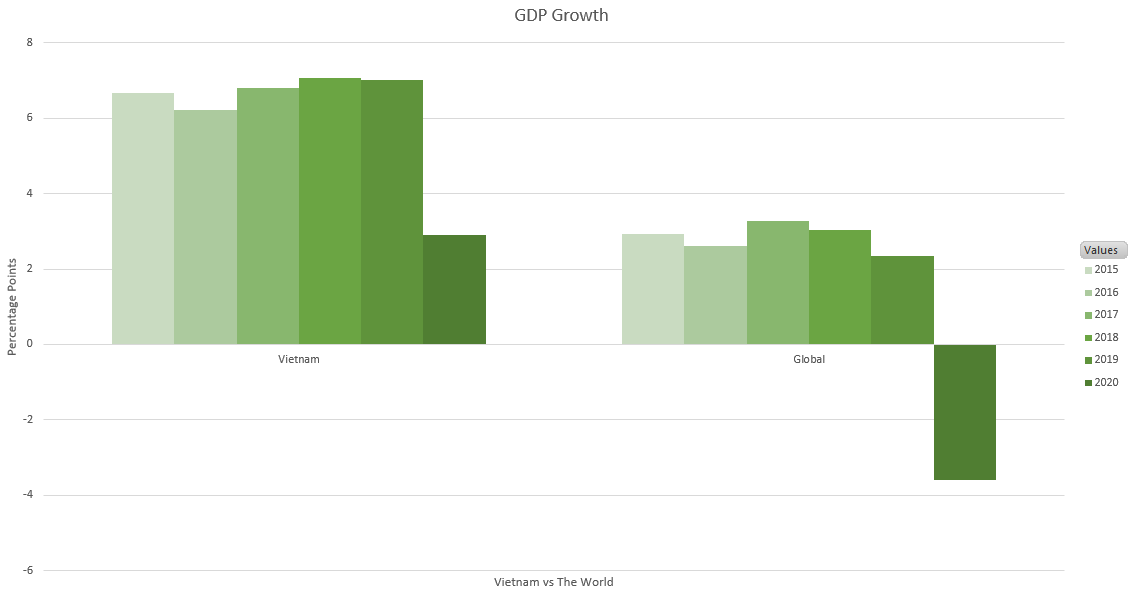

That growth has a number of trickle-down effects. One of these seems to be that more and more people are able to afford their own motorcycle. 

#### Vehicle Sales

A motorcycle greatly increases quality of life and brings more opportunities within reach. When given the choice between bicycles, aging bus networks, and motorcycles people tend towards the latter.

This has lead to a country with strong vehicle sales that seem to remain constant year-to-year.

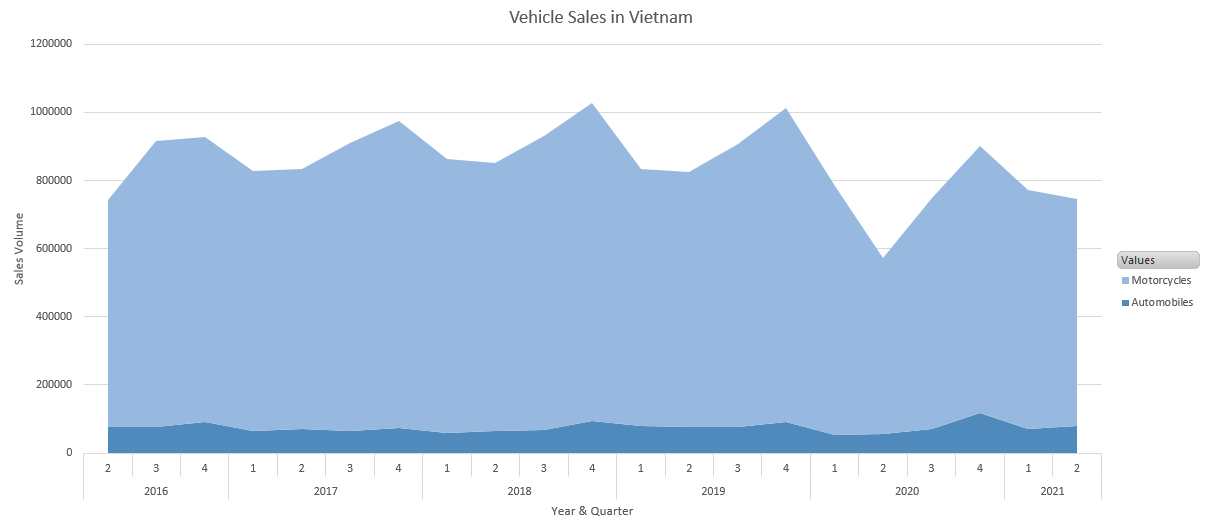

Unfortunately, what is such a benefit for individuals is actually a detriment to the popuation as a whole- especially in the larger cities.

#### The State of Air

A recent emissions mapping study found that within Ho Chi Minh City, transportation- specifically motorcycles- were the biggest contributer to air pollution within the city.

Let's take a moment to consider the air quality index measurement we are using. This scale ranges from 0 for perfectly clear and unpolluted air to 500, which is considered the most hazardous. 

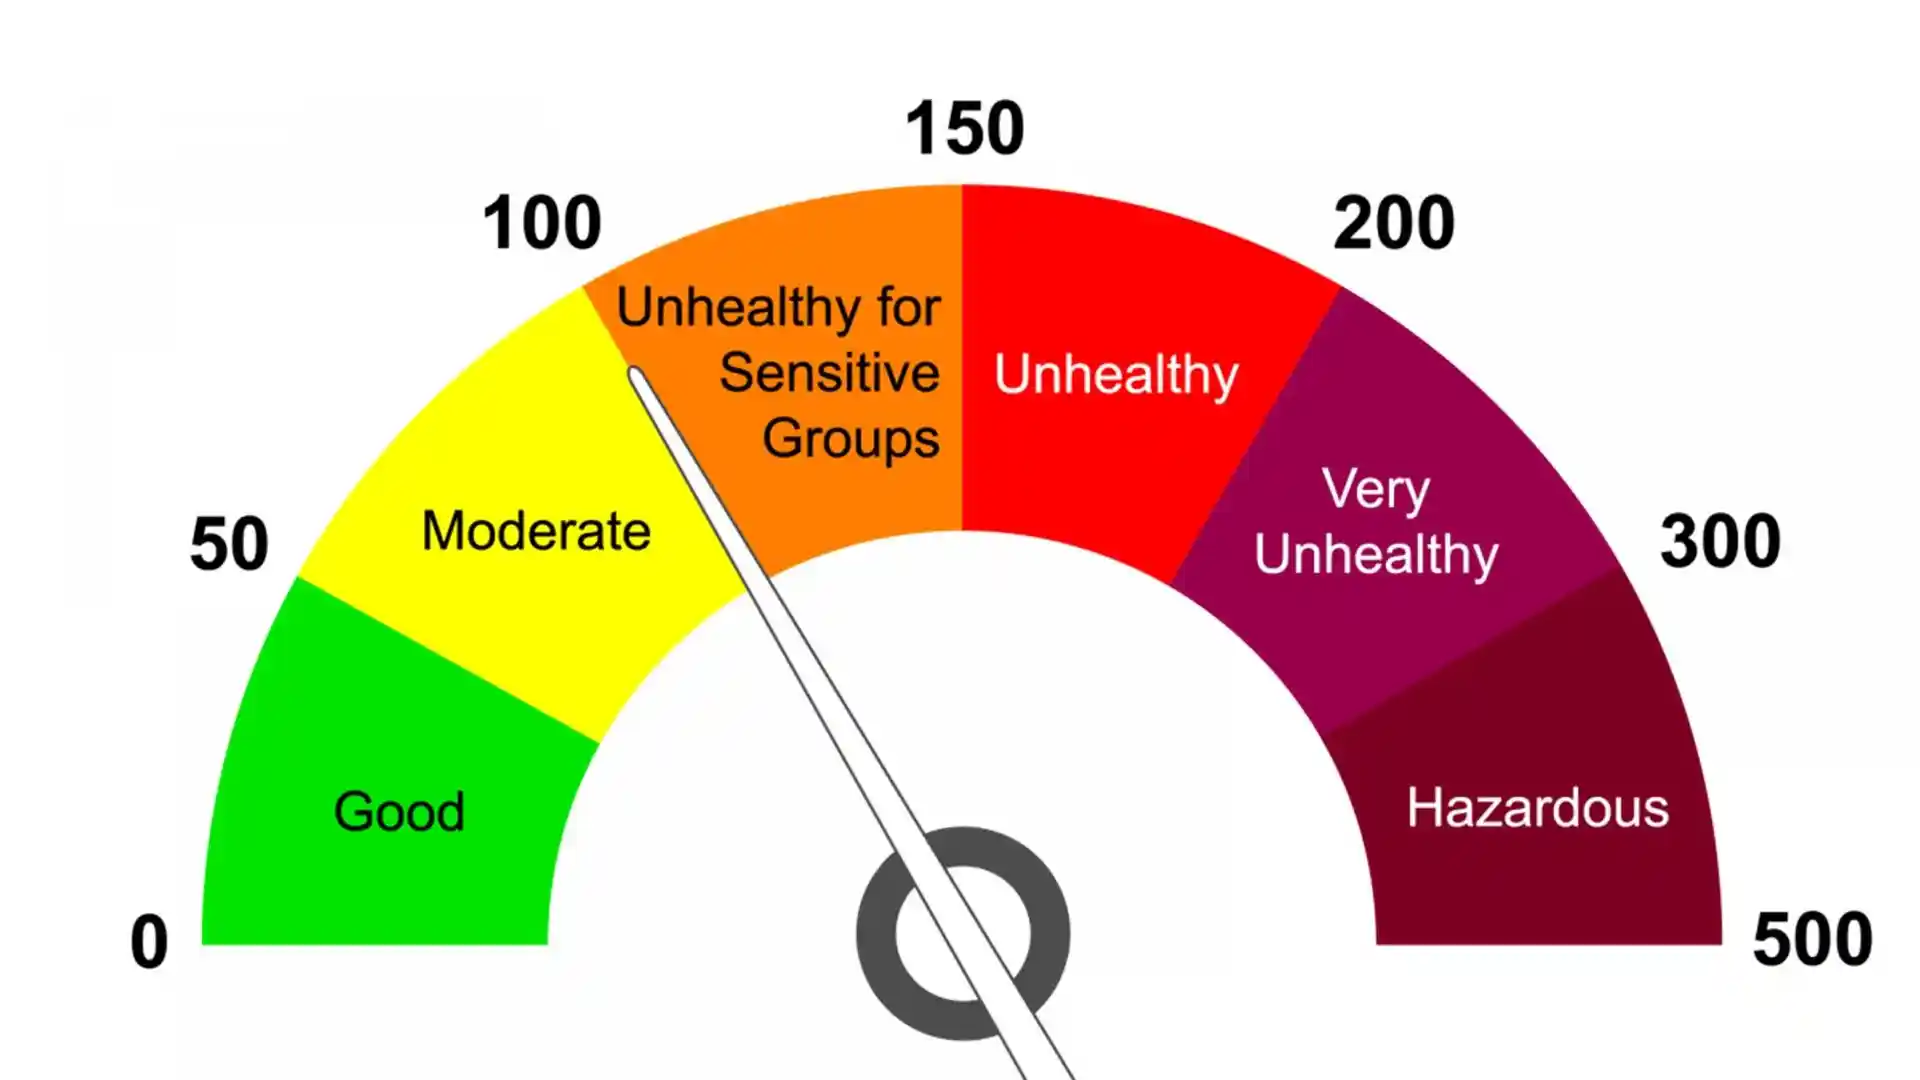

*Image courtesy of [Blue Sky Analytics](https://blueskyhq.in/blog/what-is-air-quality-index-aqi-and-why-is-it-important#close-cookie])*

In this analysis, the air pollution data was measured on the AQI (Air Quality Index) scale which is a measure of the quality of Air ([AQI Basics](https://www.airnow.gov/aqi/aqi-basics/#:~:text=Air%20Quality%20Index%20(AQI)%20AQI,Professionals%20Air%20Quality%20Awareness%20Week)). 

Let's consider air pollution in the two major cities. Here is a chart detailing monthly averages in HCMC from 2016 to July 2021:

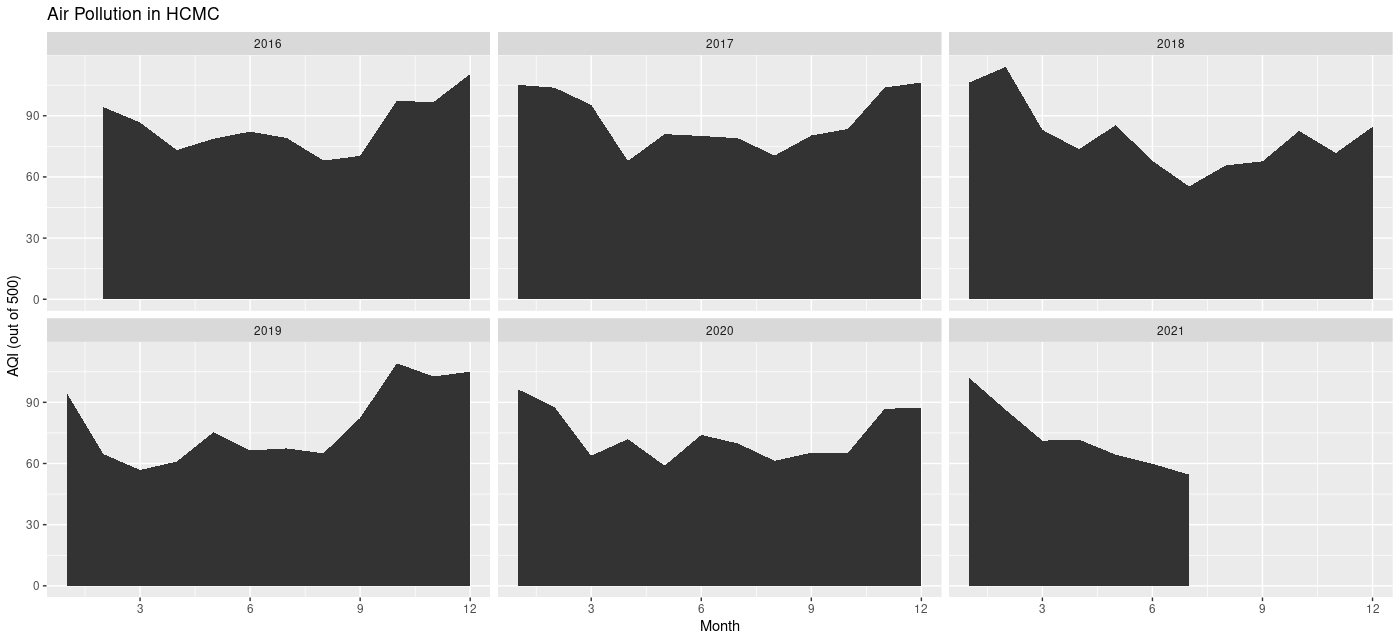

Compare that with Hanoi's level of air pollution. Both the levels and the trends are quite similar. 

*Note: data for much of 2019 was corrupted, but followed similar trends to surrounding years*

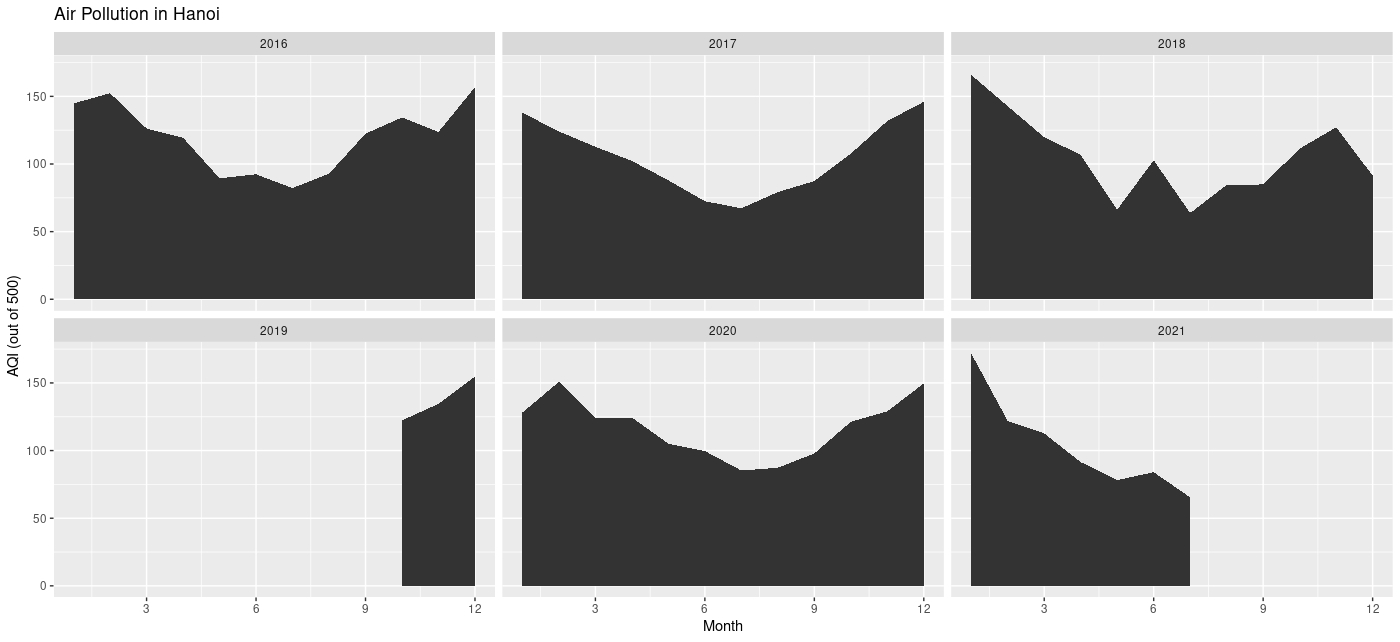

Over this five-year period of time, Ho Chi Minh City's average air quality index (averaged over the time period studied) came out to an AQI of over 80. The daily average highs have reached 161 in 2016 and almost 163 in 2021. It otherwise dwelled in the mid to high 140s of the index.

But a moderate *average* score does not tell the whole story. Of the hours analyzed, 20% of the time, Ho Chi Minh City's score was above 100 and 5% of the time (over all) it exceeded 150 on the index. 

The quality of air in Hanoi is even poorer, with an average AQI reading of 112. Its daily average highs have reached over 232 and 235 in the last two years. In every year analyzed this number exceeded 200 on the index.

The percentage of time categorized as "unhealthy" is even more disheartening. The AQI rating is above 100 over 51% of the time and exceeds 150 more than 26% of the time over all. 

#### Air Pollution and Traffic

It's often been estimated that 60-70% of air pollution in big cities is directly due to the traffic. One recent study ([Emission Mapping of... Ho Chi Minh City...](https://acp.copernicus.org/articles/21/2795/2021/acp-21-2795-2021-discussion.html)) has specifically linked motorcycles in HCMC to 95% of total CO (carbon monoxide) emission, 50-60% of CO2 (carbon dioxide) emission and 14% of NOx (nitric oxide).

The study also found that heavy vehicles are the biggest emission source of NOx, SO2 (sulfur dioxide), and PM (particulate matter), while personal cars are the largest contributors to NMVOC (non-methane volatile organic compounds) and CO2.

There are approximately 67 million motorcycles currently in circulation and significantly fewer cars and heavy vehicles. Data was not found to confirm numbers of non-motorcycle automobiles, but based on sales data already considered it is likely that these figures are far under 10% the number of motorcycles in use throughout the country.

**Access study details [[here](https://acp.copernicus.org/articles/21/2795/2021/acp-21-2795-2021-discussion.html)] or download the full study [[here](https://acp.copernicus.org/articles/21/2795/2021/acp-21-2795-2021.pdf)].*

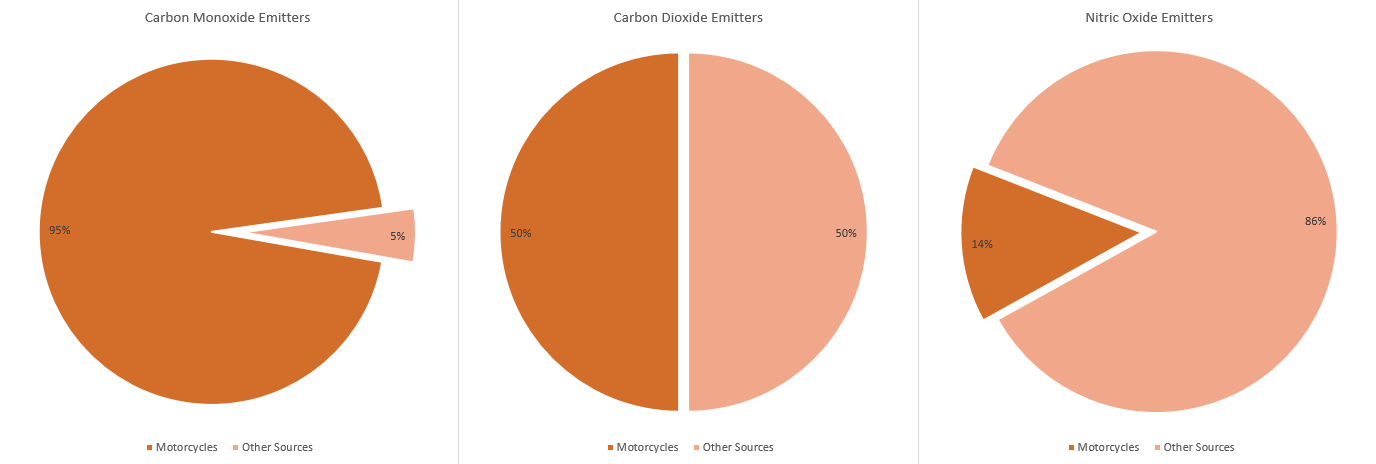

While automobiles are not off the hook, it is plain to see that especially in the cities motorcycles are largely to blame for the current status of the air.

#### The Sad Truth

Vehicle sales and air pollution seem to be here to stay, unless something is done to address them. The clear trend is a steady maintenance of both vehicle sales and air pollution levels. Fortunately, the latter is not rising. But it is dangerous to allow it to continue at its current harmful levels. 

Air pollution has been connected to millions of deaths due to heart disease, stroke, lung cancer and chronic respiratory disease ([Ambient Air Pollution](https://www.who.int/teams/environment-climate-change-and-health/air-quality-and-health/ambient-air-pollution), WHO).

Vietnam ranks fourth amongst a number countries with the largest number of motorcycles ([Hanoi Times](http://hanoitimes.vn/vietnam-ranks-fourth-among-countries-with-largest-number-of-motorcycles-46205.html)). Based on 2019 estimates, that puts the amount of motorbikes in use as high as 67 million andis continuing to increase with no signs of change. Air pollution has rightly been blamed largely on the traffic (HCMC Blames Motorbike Population, [VNExpress](https://e.vnexpress.net/news/news/hcmc-blames-motorbike-population-for-alarming-pollution-4237219.html))).

In addition to death it is also a major cause of many other conditions that severely affect and often incapacitate many (Air Pollution and Chronic Airway Diseases, [NIH Study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4740163/)). This is already becoming far too evident in Vietnam (Vietnam's Silent Killer, [Vietnam Investment Review](https://vir.com.vn/air-pollution-is-vietnams-silent-killer-56542.html)).

This is quite clearly a top concern amongst Vietnamese citizens (Top Environmental Concern, [VNExpress](https://e.vnexpress.net/news/news/air-pollution-top-environmental-concern-among-vietnamese-citizens-4247705.html)), but many aren't even aware of what AQI is (over 40% one survey claims).

Some steps have been taken, such as measures recently instituted to remove outdated high-polluting vehicles from the road (Government Directive, [VNExpress](https://e.vnexpress.net/news/news/hanoi-hcmc-must-get-rid-of-outdated-vehicles-to-protect-environment-government-directive-4223195.html)). The Ho Chi Minh City metro line can also stand to contribute, though the start date has been pushed further now into 2022 (Pushed Back to 2022, [VNExpress](https://e.vnexpress.net/news/news/saigon-1st-metro-line-completion-pushed-back-to-2022-4237020.html)).

Even with some initiative being taken, there is much more to be done. Air pollution is a big problem and will not be solved without concerted effort.



### <center> Next Steps </center>

As much character as the motorcycle brings to Vietnam, it also bring a similar amount of disease. Vietnam and the general public needs to come to terms with this.

After all, the first step of solving a problem is addressing that you have one.

#### Education

Therefore, it is important to educate the public regarding 
* the presence and harm of air pollution 
* how to protect yourself and loved ones
* how to reduce your contribution to the problem


In addition to education (and more importantly), transitioning the general public from motorcycles and onto public transportation would likely drastically lower air pollution.

#### Public Transportation

There needs to be an much-increased emphasis on improving current public transportation infrastructure and implementing new systems, such as the Ho Chi Minh City metro, so that citizens can transition away from the motorcycles or cars and onto the the bus or rail.

Despite all the harm motorcycles may cause the environment, they are often the only affordable option for many, if not most, families. 

#### (Dis)Incentives

Congestion charges (a la London), emissions taxes, incentives for greener vehicles and the like are effective solutions. **But first, there need to be sensible alternatives to personal transportation. Otherwise change would be damaging to the community that it is trying to help.** 

To see other non-traffic possibilities for reducing air pollution please reference the article "Vietnam’s Big Air Pollution Challenge," which lists some additional ideas that extend beyond the scope of this analysis: [The Diplomat](https://thediplomat.com/2020/03/vietnams-big-air-pollution-challenge/)


**Finally,** further analysis and research need to be conducted regarding public opinion on public transportation opinions, effective forms of public health and environmental education and the most effective approaches to the implementation of the various solutions as listed above.

__


Pollution is no easy problem to solve, but it *is* possible to solve. What is more, we have already taken some steps in the right direction. But we need to do more.

<style>
    table {
        display: inline-block
![metroso1huukhoa196311602566266-4243-5444-1617422160_680x408.jpeg](attachment:metroso1huukhoa196311602566266-4243-5444-1617422160_680x408.jpeg)

Image by huu khoa courtesy of VNExpress}
</style>

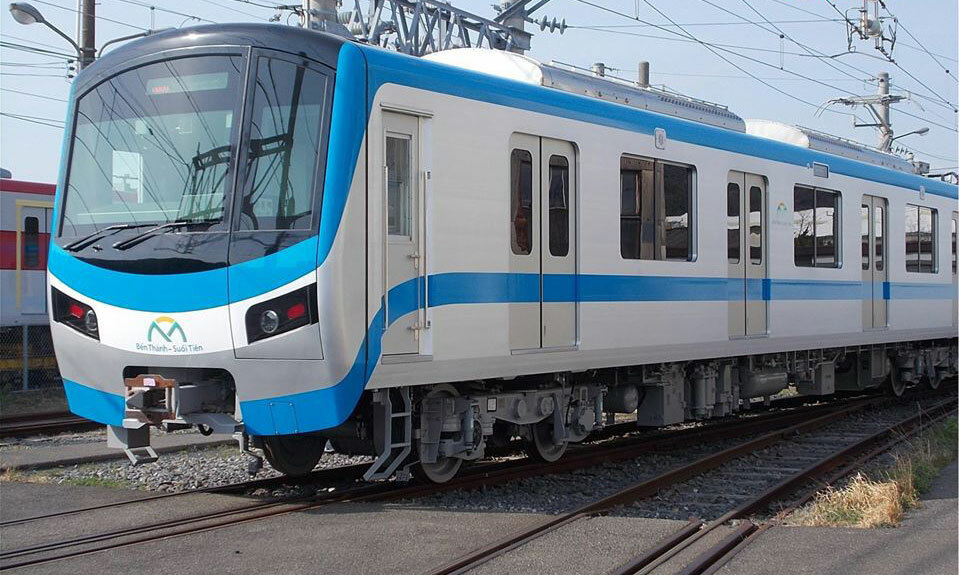

*[Image](https://vcdn-english.vnecdn.net/2020/04/13/WEBimagegallery-1586768876-3450-1586768901_1200x0.jpg) courtesy of the HCMC Management Authority for Urban Railways (MAUR) via [VNExpress](https://e.vnexpress.net/news/business/economy/first-look-at-hcmc-metro-train-4084057.html).*